# <a id='toc1_'></a>[Offline Stream Example Notebook](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Offline Stream Example Notebook](#toc1_)    
  - [Installation](#toc1_1_)    
  - [Pathing](#toc1_2_)    
- [Loading in data](#toc2_)    
- [Looking at our data](#toc3_)    
  - [Events](#toc3_1_)    
- [Epoching](#toc4_)    
  - [Creating Epochs](#toc4_1_)    
  - [Navigating the epochs dictionary](#toc4_2_)    
  - [Visualizing Epochs](#toc4_3_)    
    - [For Event-Related Potentials (ERP) - Tasks: `Oddball` & `FlickerOddball`](#toc4_3_1_)    
      - [Difference Plots](#toc4_3_1_1_)    
  - [For Steady-State Visually Evoked Potentials (SSVEP) - Task: `Flicker` & `FlickerOddball`](#toc4_4_)    
- [MNE Resources](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Installation](#toc0_)

Make sure you have the provided `Brainhack` python environment installed.

Or, at a minimum, ensure you have the following packages installed:

```bash
conda/pip install scipy jupyterlab mne matplotlib
```

In [1]:
from pathlib import Path
from glob import glob
import os.path as op
import os
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib notebook

import mne
mne.viz.set_browser_backend('matplotlib')
mne.set_log_level("WARNING")

Using matplotlib as 2D backend.


## <a id='toc1_2_'></a>[Pathing](#toc0_)
First, we need to point python to the correct place to find the files.

`source_path = op.join('..', 'eeg_data')` makes source_path a relative path to /sample-data/ which in this case is: /sample-data/

In [2]:
tasks = ['FlickerOddball', 'Flicker', 'Oddball'] # Define our three tasks

source_path = op.join('..', 'sample-data') # This is the path to our raw data

# These print statements will help you see what's inside your data directories. This can be great for troubleshooting!
print(f'Folders in "{source_path}" directory:')
print(os.listdir(source_path), "\n")

for i in tasks:
    print(f'Contents of "{op.join(source_path, i)}" directory:')
    print(f"    {os.listdir(op.join(source_path, i))} \n")

Folders in "../sample-data" directory:
['Flicker', 'Oddball', 'FlickerOddball'] 

Contents of "../sample-data/FlickerOddball" directory:
    ['sub-010_FlickerOddball_eeg.fif'] 

Contents of "../sample-data/Flicker" directory:
    ['sub-010_Flicker_eeg.fif'] 

Contents of "../sample-data/Oddball" directory:
    ['sub-010_Oddball_eeg.fif'] 



---
# <a id='toc2_'></a>[Loading in data](#toc0_)

This loop will iterate through tasks and subjects, find the .fif file for that subject and task, load it, and add it to a dictionary for us to use.

This data is loaded in as a [MNE Raw object](https://mne.tools/stable/generated/mne.io.Raw.html).

**Keep in mind, you don't have to load data in this way**, this is just an example to get you started!

In [3]:
raws_dict = dict() # This will be a dictionary that holds all of our raw data in format {task: {subject: raw_object}}

for task in tasks:
    
    task_dir = op.join(source_path, task) # This is the path to the task directory
    
    all_subjs = sorted([sub.split(os.sep)[-1].split('_')[0] for sub in glob(task_dir + '/' + '*.fif')]) # This is a list comprehension that will find all the subject ids in the `task_dir` directory

    print(f"Subjects found: {all_subjs}")

    for subject in all_subjs:
        
        raws_dict[task] = {} # This will create a dictionary for the task
        
        subject_path = glob(op.join(task_dir + '/' + subject + '*_eeg.fif')) # This is the path to the raw data file
        
        print(f"Reading data from: {subject_path}\n")
        
        # This will read in the raw data and store it in our dictionary
        raws_dict[task][subject] = mne.io.read_raw_fif(subject_path[0],  # Because glob gives us a list, we need to index to the first item (even though there is only one item in the list)
                                                    preload=True, # This line preloads the data into memory for us to use!
                                                    verbose=False
                                                ) 

Subjects found: ['sub-010']
Reading data from: ['../sample-data/FlickerOddball/sub-010_FlickerOddball_eeg.fif']

Subjects found: ['sub-010']
Reading data from: ['../sample-data/Flicker/sub-010_Flicker_eeg.fif']

Subjects found: ['sub-010']
Reading data from: ['../sample-data/Oddball/sub-010_Oddball_eeg.fif']



Lets take a quick look at our dictionary to make sure it loaded correctly!

This looks great! A quick sanity check to ensure that you haven't make a mistake like duplicating the same participant's data repeatedly, is that they will all have slightly different lengths/sizes.

In [4]:
raws_dict # You can access an entire task with raws_dict['task_name'] or a specific subject with raws_dict['task_name']['subject_id']

{'FlickerOddball': {'sub-010': <Raw | sub-010_FlickerOddball_eeg.fif, 33 x 344488 (344.5 s), ~86.8 MiB, data loaded>},
 'Flicker': {'sub-010': <Raw | sub-010_Flicker_eeg.fif, 33 x 233515 (233.5 s), ~58.8 MiB, data loaded>},
 'Oddball': {'sub-010': <Raw | sub-010_Oddball_eeg.fif, 33 x 342532 (342.5 s), ~86.3 MiB, data loaded>}}

---
# <a id='toc3_'></a>[Looking at our data](#toc0_)

Let just look at a single subject for now. Here we can see general information about the data such as number of EEG and EOG channels, how long the recording is, the sampling rate, if any filters are applied, etc.
- For more information on the metadata that can be accessed, see the [MNE '.info' documentation](https://mne.tools/stable/generated/mne.Info.html)

In [5]:
raws_dict['FlickerOddball']['sub-010']

<Raw | sub-010_FlickerOddball_eeg.fif, 33 x 344488 (344.5 s), ~86.8 MiB, data loaded>

In [6]:
raws_dict['FlickerOddball']['sub-010'].info['ch_names']

['Fp1',
 'Fp2',
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'FC5',
 'FC1',
 'FC2',
 'FC6',
 'T7',
 'C3',
 'Cz',
 'C4',
 'T8',
 'TP9',
 'CP5',
 'CP1',
 'CP2',
 'CP6',
 'TP10',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'PO9',
 'O1',
 'Oz',
 'O2',
 'PO10',
 'HEOG']

---
## <a id='toc3_1_'></a>[Events](#toc0_)

Lets take a closer look at the events from one of our subjects! 
Events are like flags that we plant in the data when something of interest occurs in the stimulus paradigm.
- `events` are the numbers associated with the markers in the data. This is an array of shape (n_events, 3) -> (event_sample, 0, event_number); the middle column is typically always 0.
- `event_id`: are the (human-readable) strings associated to the events. This is a dictionary of {event_string: event_num}

**For more information on the events for each condition in this dataset, please refer to the `dataset_description.md` file in the hackathon repository!**

For more general information, check out MNE Events Tutorials
- [Working with events](https://mne.tools/stable/auto_tutorials/raw/20_event_arrays.html)

In [7]:
events, event_id = mne.events_from_annotations(raws_dict['FlickerOddball']['sub-010'],  # This will extract the events from the raw data
                                               verbose = False)

print(f"Our event_id dictionary:")

event_id

Our event_id dictionary:


{np.str_('FlickerOddball/block_0/block_end'): 1,
 np.str_('FlickerOddball/block_0/nontarget/loc_1/freq_10'): 2,
 np.str_('FlickerOddball/block_0/nontarget/loc_2/freq_12'): 3,
 np.str_('FlickerOddball/block_0/nontarget/loc_3/freq_10.43'): 4,
 np.str_('FlickerOddball/block_0/nontarget/loc_4/freq_11.43'): 5,
 np.str_('FlickerOddball/block_0/nontarget/loc_5/freq_10.91'): 6,
 np.str_('FlickerOddball/block_0/target/loc_0/freq_12.63'): 7,
 np.str_('FlickerOddball/block_1/block_end'): 8,
 np.str_('FlickerOddball/block_1/nontarget/loc_0/freq_12.63'): 9,
 np.str_('FlickerOddball/block_1/nontarget/loc_1/freq_10'): 10,
 np.str_('FlickerOddball/block_1/nontarget/loc_2/freq_12'): 11,
 np.str_('FlickerOddball/block_1/nontarget/loc_3/freq_10.43'): 12,
 np.str_('FlickerOddball/block_1/nontarget/loc_4/freq_11.43'): 13,
 np.str_('FlickerOddball/block_1/target/loc_5/freq_10.91'): 14,
 np.str_('FlickerOddball/block_2/block_end'): 15,
 np.str_('FlickerOddball/block_2/nontarget/loc_0/freq_12.63'): 16,
 np.st

Here we can see our events with important things like 'target' and 'nontarget' markers!

Below, we can see the first 15 events in our data. The first column is the sample number, and the third column is the event type.
- For example, the first event is a '5' which, if we compare to the above event_id dictionary, corresponds to 'FlickerOddball/block_0/nontarget/loc_1/freq_10'

In [8]:
print(f"The first 15 items in our events array:")

events[:15]

The first 15 items in our events array:


array([[33646,     0,     5],
       [34407,     0,     3],
       [35167,     0,     6],
       [35929,     0,     7],
       [36688,     0,     2],
       [37449,     0,     4],
       [38210,     0,     2],
       [38970,     0,     6],
       [39731,     0,     3],
       [40492,     0,     7],
       [41252,     0,     4],
       [42013,     0,     5],
       [42773,     0,     7],
       [43534,     0,     2],
       [44295,     0,     5]])

Lets quickly plot our raw data with events!

On the y-axis are the channels, x-axis the time. Each vertical line represents an event marker at that sample in the data. At the top are the event_id strings, but there are too many so they overlap. In general this doesn't tell us much more than 1. our data loaded in correctly, and 2. it needs to be cleaned as there is a lot of noise.

<IPython.core.display.Javascript object>

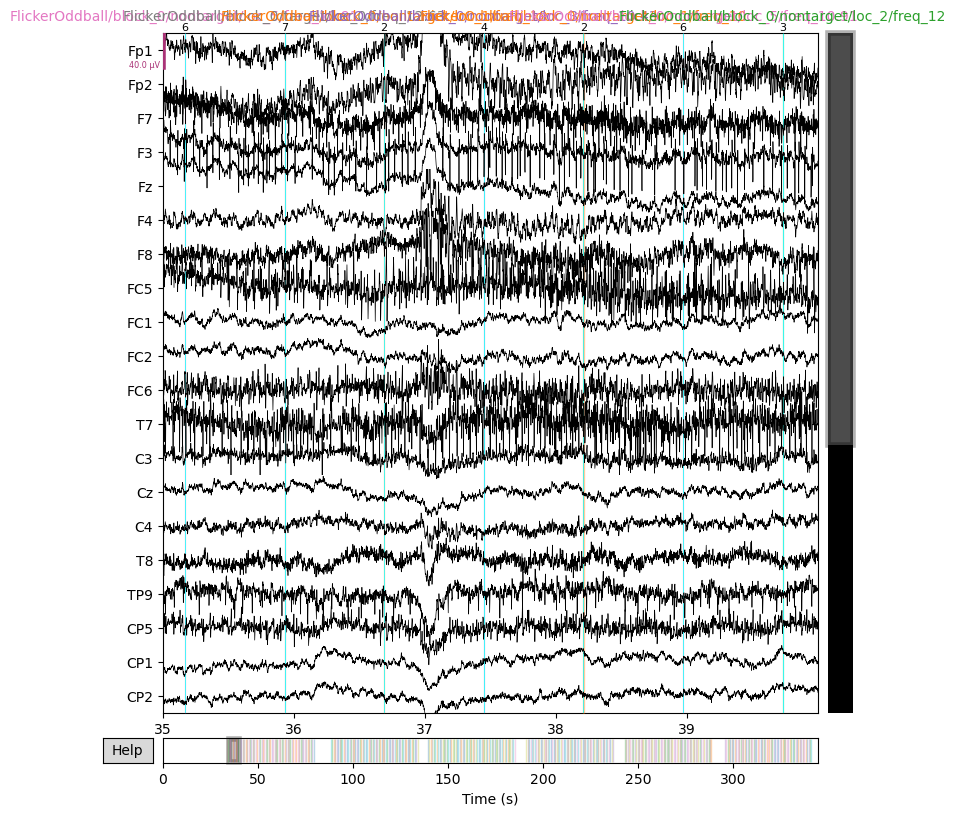

In [9]:
raws_dict['FlickerOddball']['sub-010'].plot( # This will plot from 32 into our recording for 5 seconds of our raw data for selected task and subject
    events = events,
    start = 35,
    duration = 5
)

---
# <a id='toc4_'></a>[Epoching](#toc0_)

**NOTE:** Epoching is an important step for EEG classification, however it should be **done only after most other preprocessing & cleaning steps** such as filtering and artifact removal. That is to say, **you shouldn't epoch the raw data immediately** (like I do here)! This is just an example to get you started.


Epochs are segments of data that are time-locked to an event of interest. For example, we may want to look at the brain activity 200ms before and 800ms after a 'target' event. This is also what will be used for training machine learning models. The goal is to have a classifier that can predict if an epoch is a 'target' or 'nontarget/noise' based on the brain activity in that time window. If we can do this, we can then use that classifier to predict if a person is attending to a stimulus in real-time.

For more information on epochs, check out the MNE Epochs & Tutorials:
- [Epochs documentation](https://mne.tools/stable/generated/mne.Epochs.html)
- [Divide Continuous Data into Equally-spaced epochs](https://mne.tools/stable/auto_tutorials/epochs/60_make_fixed_length_epochs.html#sphx-glr-auto-tutorials-epochs-60-make-fixed-length-epochs-py)

## <a id='toc4_1_'></a>[Creating Epochs](#toc0_)

Here, I will show you how to create epochs around **all events** for one subject. Keep in mind you may not want to use all events, depending on your analysis!

I have adjusted this loop so that you can create different epoch lengths for each task. See the `epoch_times` dictionary below.

**Hints:** Make sure to adjust tmin and tmax based on your specific needs and the timing of your events!
- Make sure you refer to the `dataset_description.md` file in the hackathon repository for timing information about each task.
- for SSVEP data, having longer epochs (e.g., 3+ seconds) may be beneficial to capture the steady-state response.
- for ERP data, shorter epochs (e.g., ~1 second) are often sufficient to capture the transient responses.

In [ ]:
epoch_times = {
    'FlickerOddball': (-0.200, 0.500),
    'Flicker': (0.000, 5.000),
    'Oddball': (-0.200, 0.500)
}


epochs_dict = dict()

for task in raws_dict:
    
    epochs_dict[task] = {}
    
    tmin, tmax = epoch_times[task]
    
    print(f"Epoching task: {task} with {tmax + abs(tmin)}s epochs [{tmin}, {tmax}]")
    
    for subject in raws_dict[task]:
        
        # Extract events and event_id from the raw data
        events, event_id = mne.events_from_annotations(raws_dict[task][subject], verbose=False)
        
        # Create epochs around all events (customize event selection as needed)
        epochs = mne.Epochs(
            raws_dict[task][subject],
            events,
            event_id=event_id,
            tmin=tmin,   
            tmax=tmax,    
            baseline=(None, None),
            preload=True,
            verbose=False,
            picks='eeg'     # If you want to only use EEG channels for epoching (usually recommended)
        )
        
        epochs_dict[task][subject] = epochs

Epoching task: FlickerOddball with 0.7s epochs [-0.2, 0.5]
Epoching task: Flicker with 5.0s epochs [0.0, 5.0]
Epoching task: Oddball with 0.7s epochs [-0.2, 0.5]


## <a id='toc4_2_'></a>[Navigating the epochs dictionary](#toc0_)
Now, we have a dictionary of epochs for each task and subject!
To access the epochs for a specific task and subject, you can use:
```python
epochs_dict['<task>']['<subject>']
```
For example

In [11]:
epochs_dict['FlickerOddball']['sub-010']

<Epochs | 366 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0.5 s), ~62.7 MiB, data loaded,
 np.str_('FlickerOddball/block_0/block_end'): 1
 np.str_('FlickerOddball/block_0/nontarget/loc_1/freq_10'): 10
 np.str_('FlickerOddball/block_0/nontarget/loc_2/freq_12'): 10
 np.str_('FlickerOddball/block_0/nontarget/loc_3/freq_10.43'): 10
 np.str_('FlickerOddball/block_0/nontarget/loc_4/freq_11.43'): 10
 np.str_('FlickerOddball/block_0/nontarget/loc_5/freq_10.91'): 10
 np.str_('FlickerOddball/block_0/target/loc_0/freq_12.63'): 10
 np.str_('FlickerOddball/block_1/block_end'): 1
 np.str_('FlickerOddball/block_1/nontarget/loc_0/freq_12.63'): 10
 np.str_('FlickerOddball/block_1/nontarget/loc_1/freq_10'): 10
 and 32 more events ...>

As you can see, all 366 events have been epoched around. 
- 60 'target' epochs
- 300 'nontarget' epochs
- 6 'block_end' epochs
Since they aren't relevant for classification, the 'block_end' epochs can typically be removed or ignored.

If we want to select only some of our events, we can do that with indexing. For example:

In [12]:
epochs_dict['FlickerOddball']['sub-010']['target']

<Epochs | 60 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0.5 s), ~10.3 MiB, data loaded,
 np.str_('FlickerOddball/block_0/target/loc_0/freq_12.63'): 10
 np.str_('FlickerOddball/block_1/target/loc_5/freq_10.91'): 10
 np.str_('FlickerOddball/block_2/target/loc_1/freq_10'): 10
 np.str_('FlickerOddball/block_3/target/loc_2/freq_12'): 10
 np.str_('FlickerOddball/block_4/target/loc_3/freq_10.43'): 10
 np.str_('FlickerOddball/block_5/target/loc_4/freq_11.43'): 10>

As you can see, we have selected only the 'target' epochs for this subject and task. This is useful for classification - i.e, 'target' vs 'nontarget' epochs!

---
## <a id='toc4_3_'></a>[Visualizing Epochs](#toc0_)

In this section, I will show you how to create some basic informative visualizations your epochs. Keep in mind these visualizations are using **raw data, so the visualizations here are uninformative and noisy.**

Additional resources:
- [Visualizing Epoched Data](https://mne.tools/stable/auto_tutorials/epochs/20_visualize_epochs.html#sphx-glr-auto-tutorials-epochs-20-visualize-epochs-py)

### <a id='toc4_3_1_'></a>[For Event-Related Potentials (ERP) - Tasks: `Oddball` & `FlickerOddball`](#toc0_)

While not necessary for cleaning, preprocessing, or classification, it can be useful to visualize your epochs. This can help you identify any remaining artifacts or issues in the data - or before and after cleaning/preprocessing steps.

Visualizing a single epoch isn't typically informative, but averaging across many epochs - called "evokeds" - can reveal event-related potentials (ERPs) or other consistent patterns in the data (especially if all targets or nontargets have been averaged together).

For example, here we can see an averaged plot for all 'target' epochs (60) for this subject and task.

<IPython.core.display.Javascript object>

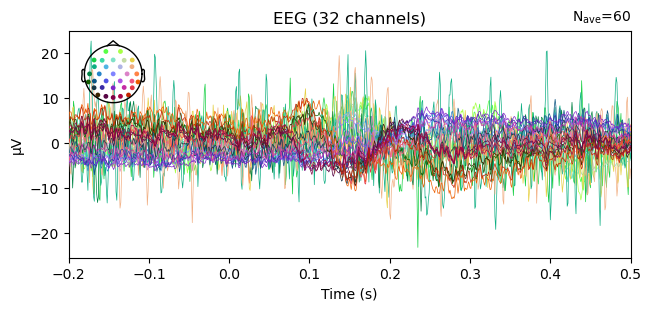

In [13]:
evoked_target = epochs_dict['Oddball']['sub-010']['target'].average()

evoked_target.plot()

And here we can see an averaged plot for all 'nontarget' epochs (300) for this subject and task.

<IPython.core.display.Javascript object>

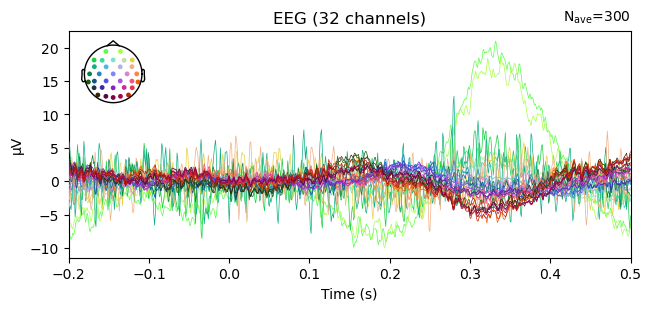

In [14]:
evoked_nontarget = epochs_dict['Oddball']['sub-010']['nontarget'].average()

evoked_nontarget.plot()

Another useful visualization is a comparison between conditions. For example, comparing the evoked responses for 'target' vs 'nontarget' epochs. - which can be done with `mne.viz.plot_compare_evokeds()`

In [15]:
mne.viz.plot_compare_evokeds(
    {'Target': evoked_target, 'Nontarget': evoked_nontarget},
    colors = {'Target': 'blue', 'Nontarget': 'orange'})

<IPython.core.display.Javascript object>

[<Figure size 800x600 with 1 Axes>]

#### <a id='toc4_3_1_1_'></a>[Difference Plots](#toc0_)
Perhaps the most informative visualization is a difference plot between two conditions, such as 'target' vs 'nontarget'. This plot is essentially a subtraction of the two averages and shows only the *difference* between the two conditions. This difference is really what enables your classifier to differentiate between target and nontargets!

Here I use `mne.combine_evoked` to create a difference wave by subtracting the nontarget evoked from the target evoked. 

**Hint:** Also notice the channel/topo map in the top left that maps each electrode channel to a location on the scalp. This can help identify where the ERP effects are strongest. (e.g., the P300 is typically strongest at parietal electrodes like Pz, and can be selected from the data via `picks=[<ch1>, <ch2>, etc.]`)


<IPython.core.display.Javascript object>

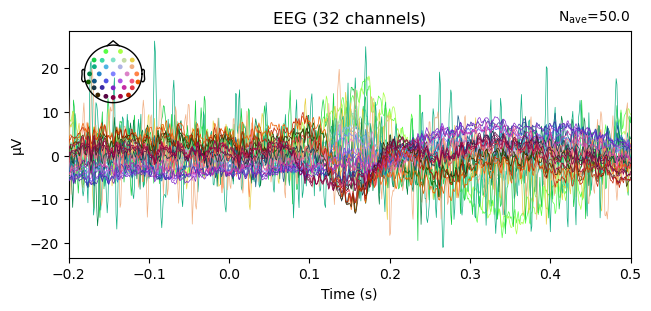

In [16]:
evoked_diff = mne.combine_evoked(
    [evoked_nontarget, evoked_target], 
    weights=[-1, 1]   # Subtract nontarget from target (target - nontarget)
    )

evoked_diff.plot()

## <a id='toc4_4_'></a>[For Steady-State Visually Evoked Potentials (SSVEP) - Task: `Flicker` & `FlickerOddball`](#toc0_)

When investigating SSVEP data, the focus is often on the frequency domain rather than time-domain averages. However, you can still visualize the averaged epochs to see the overall brain response to the flickering stimuli.

**Hint:** 
- Keep in mind that SSVEP epochs are typically much longer (e.g., 5-30 seconds) to capture the steady-state response.
- SSVEP responses are typically characterized by increased power at the stimulus frequency and its harmonics. Therefore, frequency analysis (e.g., using Fourier Transform or wavelet analysis) is often more informative for SSVEP data than time-domain averages.

Here I show a quick loop that creates one spectrum object and plot for each flicker frequency in the `Flicker` task for this subject.

**Hint:** You can adjust the `fmin` and `fmax` parameters in `plot()` to zoom in on specific frequency ranges of interest.

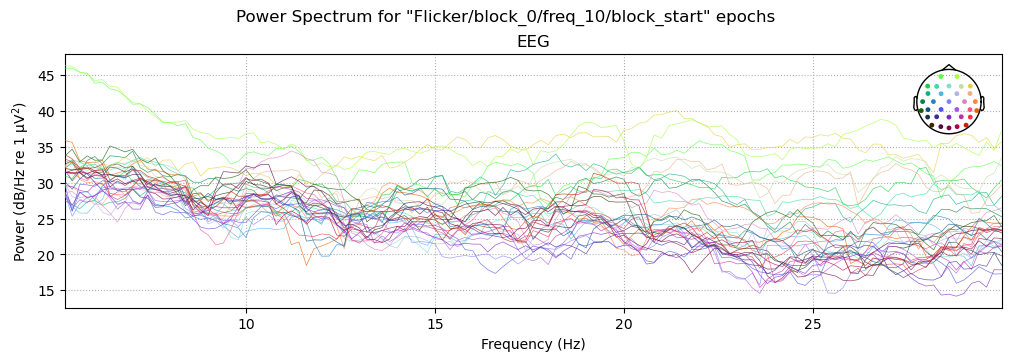

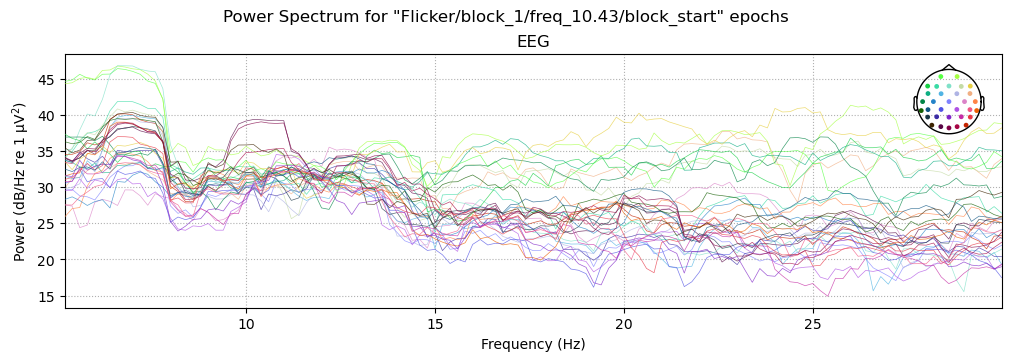

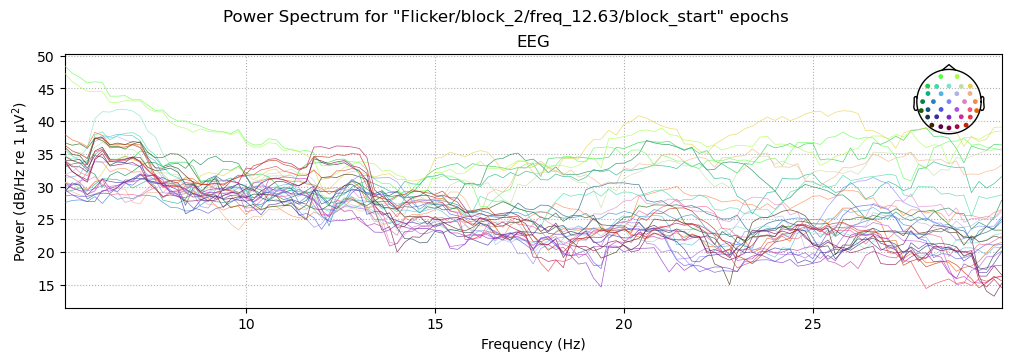

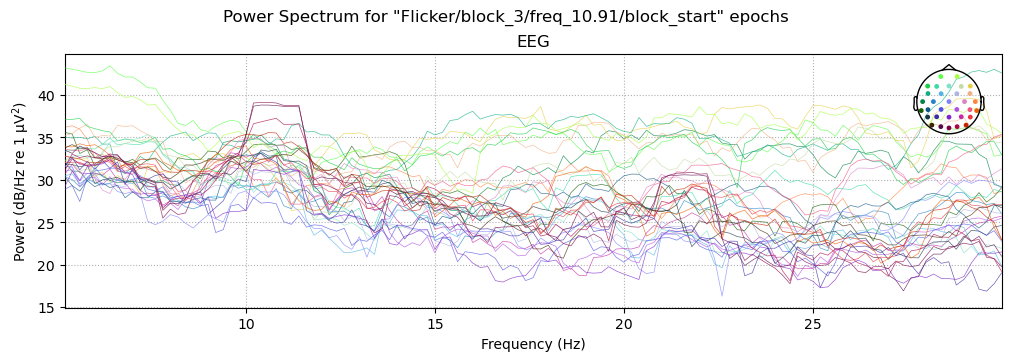

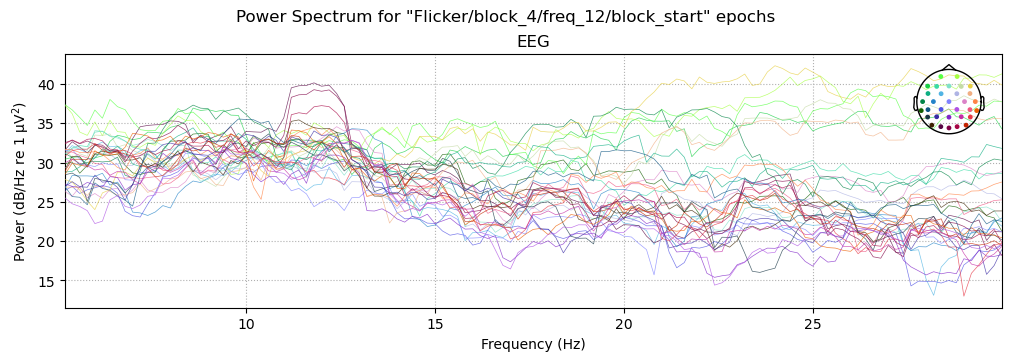

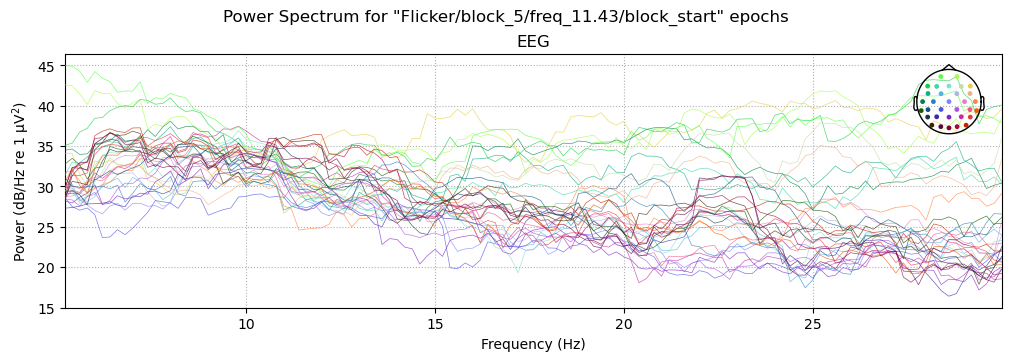

In [17]:
%matplotlib inline
# Here I make a list of all the epochs that I want to create spectra for (only 'block_start' epochs in this case)
epochs_of_interest = epochs_dict['Flicker']['sub-010']['block_start'].event_id

for freq in epochs_of_interest:
    
    spectrum = epochs_dict['Flicker']['sub-010']['block_start'][freq].compute_psd(fmin=5, fmax=30)

    # There is a little bit of matplotlib code to set the title of each figure.
    fig = spectrum.plot(show=False)
    fig.suptitle(f'Power Spectrum for "{freq}" epochs')  # Set the figure title
    plt.show()


In each plot (some more than others), you can see a peak at the flicker frequency (e.g., 10 Hz, 12 Hz, etc.) and its harmonics (e.g., 20 Hz, 30 Hz, etc.). This indicates that the brain is entrained to the flickering stimulus at that frequency - at that is something we can use to classify attention to different flicker frequencies!

**Hint:**
- Check out the real-time stream's example notebook as well! There might be more information on classification there!
- Make note that different channels/electrodes show different levels of response, so selecting only specific channels could improve classification performance.
- The `EpochsSpectrum` ('spectrum' variables above) objects hold lots of useful information and methods for further analysis and/or classification. 

---

# <a id='toc5_'></a>[MNE Resources](#toc0_)
- [EEG Analysis - ERPs](https://mne.tools/stable/auto_tutorials/evoked/30_eeg_erp.html#sphx-glr-auto-tutorials-evoked-30-eeg-erp-py)
- [Time-Frequency Analysis - SSVEPs](https://mne.tools/stable/auto_tutorials/time-freq/index.htmlhttps://mne.tools/stable/auto_tutorials/time-freq/index.html)
  - [General API/Information on `EpochsSpectrum`](https://mne.tools/stable/generated/mne.time_frequency.EpochsSpectrum.html#mne.time_frequency.EpochsSpectrum)
- [Visualizing Epoched Data](https://mne.tools/stable/auto_tutorials/epochs/20_visualize_epochs.html#sphx-glr-auto-tutorials-epochs-20-visualize-epochs-py)
- [Machine Learning (Decoding, Encoding, and MVPA)](https://mne.tools/stable/auto_examples/decoding/index.html#machine-learning-decoding-encoding-and-mvpa)